# Setup

In [1]:
# Import das bibliotecas
import requests
from bs4 import BeautifulSoup
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


# Análise Exploratória dos Dados

## Obtenção dos dados 
### Web Scrapping

In [51]:
# Obtenção da lista de links 

url = 'https://en.wikipedia.org/wiki/Copa_Am%C3%A9rica'
resp = requests.get(url)
soup_links = BeautifulSoup(resp.text)
ancoras = (soup_links.find("div", class_ ="hlist nowraplinks"))

links = []
for link in ancoras.find_all('a'):
    links.append("https://en.wikipedia.org"+link.get('href'))
    

In [88]:
# Obtenção dos dados de cada link

data = []
for url in links:
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text)
    paragrafo = soup.find("table", class_='infobox vcalendar').find("tbody").find_all("tr")
    mydict = {}
    rows = ['Host country', 'Dates', 'Teams', 'Venue(s)', 'Champions', 'Runners-up', 'Third place', 'Fourth place', 'Matches played', 'Goals scored', "Attendance"]
    for i in range(len(paragrafo)):
        mydict['Edition'] = (soup.find(class_="infobox-title summary").text)
        if paragrafo[i].find(string=rows):
            mydict[paragrafo[i].th.text] = paragrafo[i].td.get_text(strip=True)
    mydict['Link'] = url
    data.append(mydict.copy()) 
    

In [93]:
# Save dos dados raspados em arquivo .pkl
data = pd.DataFrame(data)
data.to_pickle('dados_copa_raw.pkl')

## Pré-processamento dos dados

In [2]:
# Criação do dataframe com os dados raspados
df = pd.read_pickle('dados_copa_raw.pkl')
df.tail()

,Edition,Host country,Dates,Teams,Venue(s),Champions,Runners-up,Third place,Fourth place,Goals scored,Link,Attendance
43,2015 Copa América,Chile,11 June – 4 July,12 (from 2 confederations),9 (in 8 host cities),Chile(1st title),Argentina,Peru,Paraguay,59 (2.27 per match),https://en.wikipedia.org/wiki/2015_Copa_Am%C3%...,"655,902 (25,227 per match)"
44,Copa América Centenario,United States,June 3–26,16 (from 2 confederations),10 (in 10 host cities),Chile(2nd title),Argentina,Colombia,United States,91 (2.84 per match),https://en.wikipedia.org/wiki/Copa_Am%C3%A9ric...,"1,483,855 (46,370 per match)"
45,2019 Copa América,Brazil,14 June – 7 July,12 (from 2 confederations),6 (in 5 host cities),Brazil(9th title),Peru,Argentina,Chile,60 (2.31 per match),https://en.wikipedia.org/wiki/2019_Copa_Am%C3%...,"867,245 (33,356 per match)"
46,2021 Copa América,Brazil,13 June – 10 July,10 (from 1 confederation),5 (in 4 host cities),Argentina(15th title),Brazil,Colombia,Peru,65 (2.32 per match),https://en.wikipedia.org/wiki/2021_Copa_Am%C3%...,"7,800 (279 per match)"
47,2024 Copa América,United States,June 20 – July 14,16 (from 2 confederations),14 (in 14 host cities),NaN,NaN,NaN,NaN,12 (2 per match),https://en.wikipedia.org/wiki/2024_Copa_Am%C3%...,"278,519 (46,420 per match)"


In [3]:
# Rename das colunas para substituir espaços por _
df.columns = df.columns.map(lambda x: x.replace(' ', '_'))
df.head()

,Edition,Host_country,Dates,Teams,Venue(s),Champions,Runners-up,Third_place,Fourth_place,Goals_scored,Link,Attendance
0,1916 South American Championship,Argentina,2–17 July,4 (from 1 confederation),2 (in 2 host cities),Uruguay(1st title),Argentina,Brazil,Chile,18 (3 per match),https://en.wikipedia.org/wiki/1916_South_Ameri...,NaN
1,1917 South American Championship of Nations,Uruguay,30 September – 14 October,4 (from 1 confederation),1 (in 1 host city),Uruguay(2nd title),Argentina,Brazil,Chile,21 (3.5 per match),https://en.wikipedia.org/wiki/1917_South_Ameri...,NaN
2,1919 South American Championship of Nations,Brazil,11–29 May,4 (from 1 confederation),1 (in 1 host city),Brazil(1st title),Uruguay,Argentina,Chile,27 (3.86 per match),https://en.wikipedia.org/wiki/1919_South_Ameri...,NaN
3,1920 South American Championship of Nations,Chile,11–26 September,4 (from 1 confederation),1 (in 1 host city),Uruguay(3rd title),Argentina,Brazil,Chile,16 (2.67 per match),https://en.wikipedia.org/wiki/1920_South_Ameri...,NaN
4,1921 South American Championship of Nations,Argentina,2–30 October,4 (from 1 confederation),1 (in 1 host city),Argentina(1st title),Brazil,Uruguay,Paraguay,14 (2.33 per match),https://en.wikipedia.org/wiki/1921_South_Ameri...,NaN


In [163]:
# Obtenção do ano da competição
df['Year'] = df['Edition'].str.extract('(\d+)')

In [164]:
# Obtenção dos meses de início e fim da competição
df[['Start_month', 'End_month']] = (df['Dates'].apply(lambda x: ' '.join(re.findall(r'[a-zA-Z]+', x)))).str.split(' ', expand=True)
df['End_month'] = df['End_month'].fillna(df['Start_month'])

In [165]:
# Obtenção do número de participantes na competição (sem o número de confederações)
df['Teams'] = df['Teams'].str.replace(r'\s+\([^()]*\)$', '', regex=True)

In [166]:
# Obtenção do número de estádios e de cidades-sede
df[['N_of_stadiums', 'N_of_cities']] = df['Venue(s)'].apply(lambda x: pd.Series(re.findall(r'\d+', str(x)) if isinstance(x, str) else [np.nan, np.nan]))

In [167]:
# Obtenção do campeão da competição (sem o número de títuos do país)
df['Champions'] = df['Champions'].str.replace(r'\([^)]*\)', '', regex=True)

In [168]:
# Obtenção do total de gols marcados no torneio e a média por partida
df[['Total_goals', 'Average_goals']] = df['Goals_scored'].apply(lambda x: pd.Series([re.findall(r'^(\d+)', str(x))[0], re.findall(r'\(([\d\.]+)\s*per match\)$', str(x))[0]]) if isinstance(x, str) else pd.Series([np.nan,np.nan]))

In [169]:
# Obtenção do número de partidas disputadas no torneio
df['Matches_played'] = round(pd.to_numeric(df['Total_goals'], errors='coerce')/pd.to_numeric(df['Average_goals'], errors='coerce'),0)

In [170]:
# Obtenção do público total do evento e da média por partida
df['Total_attendance'] = df['Attendance'].str.extract(r'(\d{1,3}(?:,\d{1,3})*)')
df['Total_attendance'] = df['Total_attendance'].str.replace(',','')

df['Average_attendance'] = df['Attendance'].str.extract(r'(\d{1,3}(?:,\d{3})*?) per match\)')
df['Average_attendance'] = df['Average_attendance'].str.replace(',','')

## Tratamento dos dados

In [171]:
# Correção dos tipos de variáveis numéricas
to_int = ['Teams', 'Year', 'N_of_stadiums', 'N_of_cities', 'Total_goals', 'Matches_played', 'Total_attendance', 'Average_attendance']
for i in to_int:
    df[i] = pd.to_numeric(df[i], errors='coerce').astype('Int32')

df['Average_goals'] = df['Average_goals'].astype(float)

In [173]:
# Verificação dos tipos de variáveis
df.dtypes

Edition                         object
Host_country                    object
Dates                           object
Teams                            Int32
Venue(s)                        object
Champions                       object
Runners-up                      object
Third_place                     object
Fourth_place                    object
Goals_scored                    object
Link                            object
Attendance                      object
Year                             Int32
Start_month                     object
End_month                       object
N_of_stadiums                    Int32
N_of_cities                      Int32
Total_goals                      Int32
Average_goals                  float64
Matches_played                   Int32
Total_attendance                 Int32
Average_attendance               Int32
Start_month_datetime    datetime64[ns]
End_month_datetime      datetime64[ns]
dtype: object

In [174]:
# Verificação de duplicatas na coluna Edition, que funciona como ID
df[df.duplicated(subset=['Edition'], keep=False)]

,Edition,Host_country,Dates,Teams,Venue(s),Champions,Runners-up,Third_place,Fourth_place,Goals_scored,...,End_month,N_of_stadiums,N_of_cities,Total_goals,Average_goals,Matches_played,Total_attendance,Average_attendance,Start_month_datetime,End_month_datetime
25,1959 South American Championship,Argentina,7 March – 4 April,7,Monumental Stadium,Argentina,Brazil,Paraguay,Peru,86 (4.1 per match),...,April,<NA>,<NA>,86,4.1,21,<NA>,<NA>,1900-03-01,1900-04-01
26,1959 South American Championship,Ecuador,5–25 December,5,1 (in 1 host city),Uruguay,Argentina,Brazil,Ecuador,40 (4 per match),...,December,1,1,40,4.0,10,<NA>,<NA>,1900-12-01,1900-12-01


In [175]:
# Correção de duplicatas
df.loc[25,['Edition']] = '1959 South American Championship A'
df.loc[26,['Edition']] = '1959 South American Championship E'

No ano de 1959 ocorreram 2 Copa América diferentes por conta de problemas na organização do torneio.

In [176]:
# Verificação de valores nulos/faltantes
df.isna().sum()

Edition                  0
Host_country             3
Dates                    0
Teams                    0
Venue(s)                 3
Champions                1
Runners-up               1
Third_place              4
Fourth_place             5
Goals_scored             0
Link                     0
Attendance              31
Year                     1
Start_month              0
End_month                0
N_of_stadiums            4
N_of_cities              4
Total_goals              0
Average_goals            0
Matches_played           0
Total_attendance        31
Average_attendance      31
Start_month_datetime     0
End_month_datetime       0
dtype: int64

In [177]:
# Observação em relação à edição 2024
df.tail(1)

,Edition,Host_country,Dates,Teams,Venue(s),Champions,Runners-up,Third_place,Fourth_place,Goals_scored,...,End_month,N_of_stadiums,N_of_cities,Total_goals,Average_goals,Matches_played,Total_attendance,Average_attendance,Start_month_datetime,End_month_datetime
47,2024 Copa América,United States,June 20 – July 14,16,14 (in 14 host cities),NaN,NaN,NaN,NaN,12 (2 per match),...,July,14,14,12,2.0,6,278519,46420,1900-06-01,1900-07-01


No momento atual, a edição de 2024 ainda não ocorreu. Logo, espera-se ao menos um valor faltante nas colunas: Champions, Runners-up, Third_place, Fourth_place, Goals_scored, Attendance, Total_goals, Average_goals, Matches_played, Total_attendance e Average_attendance.

In [178]:
# Verificação país-sede
df[df.Host_country.isna()]

,Edition,Host_country,Dates,Teams,Venue(s),Champions,Runners-up,Third_place,Fourth_place,Goals_scored,...,End_month,N_of_stadiums,N_of_cities,Total_goals,Average_goals,Matches_played,Total_attendance,Average_attendance,Start_month_datetime,End_month_datetime
29,1975 Copa América,NaN,17 July – 28 October,10,NaN,Peru,Colombia,NaN,NaN,79 (3.16 per match),...,October,<NA>,<NA>,79,3.16,25,1053000,42120,1900-07-01,1900-10-01
30,1979 Copa América,NaN,18 July – 12 December,10,NaN,Paraguay,Chile,NaN,NaN,63 (2.52 per match),...,December,<NA>,<NA>,63,2.52,25,1144000,45760,1900-07-01,1900-12-01
31,1983 Copa América,NaN,10 August – 4 November,10,NaN,Uruguay,Brazil,NaN,NaN,55 (2.29 per match),...,November,<NA>,<NA>,55,2.29,24,1119738,46656,1900-08-01,1900-11-01


Estas 3 edições do torneio não tiveram um país fixo e suas partidas foram realizadas no país do time mandante.

In [179]:
# Verificação do número de cidades e estádios
df[df[['N_of_stadiums','N_of_cities']].isna().any(axis=1)]

,Edition,Host_country,Dates,Teams,Venue(s),Champions,Runners-up,Third_place,Fourth_place,Goals_scored,...,End_month,N_of_stadiums,N_of_cities,Total_goals,Average_goals,Matches_played,Total_attendance,Average_attendance,Start_month_datetime,End_month_datetime
25,1959 South American Championship A,Argentina,7 March – 4 April,7,Monumental Stadium,Argentina,Brazil,Paraguay,Peru,86 (4.1 per match),...,April,<NA>,<NA>,86,4.10,21,<NA>,<NA>,1900-03-01,1900-04-01
29,1975 Copa América,NaN,17 July – 28 October,10,NaN,Peru,Colombia,NaN,NaN,79 (3.16 per match),...,October,<NA>,<NA>,79,3.16,25,1053000,42120,1900-07-01,1900-10-01
30,1979 Copa América,NaN,18 July – 12 December,10,NaN,Paraguay,Chile,NaN,NaN,63 (2.52 per match),...,December,<NA>,<NA>,63,2.52,25,1144000,45760,1900-07-01,1900-12-01
31,1983 Copa América,NaN,10 August – 4 November,10,NaN,Uruguay,Brazil,NaN,NaN,55 (2.29 per match),...,November,<NA>,<NA>,55,2.29,24,1119738,46656,1900-08-01,1900-11-01


In [180]:
# Correção do número de cidades e estádios
df.loc[25,['N_of_stadiums','N_of_cities']] = 1

A edição de 1959 foi realizada em um único estádio.

In [ ]:
# Obtenção manual da quantidade de cidades e estádios

links_venues = df[df.Host_country.isna()].loc[:,'Link'].to_list()
data_venues = []

for url in links_venues:
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text)
    paragrafo = soup.find_all('div', class_='fright')
    data = []
    new_dict = {}
    mydict = {}
    for i in range(len(paragrafo)):
        new_dict['Stadium'] = paragrafo[i].find('span').get_text().split(',')[0]
        new_dict['City'] = paragrafo[i].find('span').get_text().split(',')[1]
        data.append(new_dict.copy())
    mydict['Edition'] = df.loc[df['Link'] == url, 'Edition'].values[0]
    mydict['N_of_stadiums'] = len(set([d['Stadium'] for d in data]))
    mydict['City'] = len(set([d['City'] for d in data]))
    data_venues.append(mydict.copy())

In [842]:
# Save dos dados raspados em arquivo .pkl
data_venues = pd.DataFrame(data_venues)
data_venues.to_pickle('data_venues.pkl')

In [181]:
# Correção do número de estádios e cidades
data_venues = pd.read_pickle('data_venues.pkl')
df.loc[df['Edition'].isin(data_venues['Edition']), ['Edition', 'N_of_stadiums','N_of_cities']] = data_venues.values

Foi feita uma nova raspagem para obter uma lista com as cidades e os estádios onde foram realizadas as partidas. A partir dela, foram determinadas a quantidade de cidades e estádios que receberam jogos para cada competição.

In [182]:
# Verificação de 3º colocado
df[df.Third_place.isna()]

,Edition,Host_country,Dates,Teams,Venue(s),Champions,Runners-up,Third_place,Fourth_place,Goals_scored,...,End_month,N_of_stadiums,N_of_cities,Total_goals,Average_goals,Matches_played,Total_attendance,Average_attendance,Start_month_datetime,End_month_datetime
29,1975 Copa América,NaN,17 July – 28 October,10,NaN,Peru,Colombia,NaN,NaN,79 (3.16 per match),...,October,13,11,79,3.16,25,1053000,42120,1900-07-01,1900-10-01
30,1979 Copa América,NaN,18 July – 12 December,10,NaN,Paraguay,Chile,NaN,NaN,63 (2.52 per match),...,December,13,11,63,2.52,25,1144000,45760,1900-07-01,1900-12-01
31,1983 Copa América,NaN,10 August – 4 November,10,NaN,Uruguay,Brazil,NaN,NaN,55 (2.29 per match),...,November,12,13,55,2.29,24,1119738,46656,1900-08-01,1900-11-01
47,2024 Copa América,United States,June 20 – July 14,16,14 (in 14 host cities),NaN,NaN,NaN,NaN,12 (2 per match),...,July,14,14,12,2.00,6,278519,46420,1900-06-01,1900-07-01


As edições de 75, 79 e 83 não tiveram a realização de jogo para definir o 3º e o 4º colocado.

In [183]:
# Verificação de 4º colocado
df[df.Fourth_place.isna()]

,Edition,Host_country,Dates,Teams,Venue(s),Champions,Runners-up,Third_place,Fourth_place,Goals_scored,...,End_month,N_of_stadiums,N_of_cities,Total_goals,Average_goals,Matches_played,Total_attendance,Average_attendance,Start_month_datetime,End_month_datetime
8,1925 South American Championship,Argentina,29 November – 25 December,3,2 (in 1 host city),Argentina,Brazil,Paraguay,NaN,26 (4.33 per match),...,December,2,1,26,4.33,6,<NA>,<NA>,1900-11-01,1900-12-01
29,1975 Copa América,NaN,17 July – 28 October,10,NaN,Peru,Colombia,NaN,NaN,79 (3.16 per match),...,October,13,11,79,3.16,25,1053000,42120,1900-07-01,1900-10-01
30,1979 Copa América,NaN,18 July – 12 December,10,NaN,Paraguay,Chile,NaN,NaN,63 (2.52 per match),...,December,13,11,63,2.52,25,1144000,45760,1900-07-01,1900-12-01
31,1983 Copa América,NaN,10 August – 4 November,10,NaN,Uruguay,Brazil,NaN,NaN,55 (2.29 per match),...,November,12,13,55,2.29,24,1119738,46656,1900-08-01,1900-11-01
47,2024 Copa América,United States,June 20 – July 14,16,14 (in 14 host cities),NaN,NaN,NaN,NaN,12 (2 per match),...,July,14,14,12,2.00,6,278519,46420,1900-06-01,1900-07-01


A edição de 25 só teve 3 times participantes e as edições de 75, 79 e 83 não tiveram a realização de jogo para definir o 3º e o 4º colocado.

In [184]:
# Verificação de público
df[df.Attendance.isna()]

,Edition,Host_country,Dates,Teams,Venue(s),Champions,Runners-up,Third_place,Fourth_place,Goals_scored,...,End_month,N_of_stadiums,N_of_cities,Total_goals,Average_goals,Matches_played,Total_attendance,Average_attendance,Start_month_datetime,End_month_datetime
0,1916 South American Championship,Argentina,2–17 July,4,2 (in 2 host cities),Uruguay,Argentina,Brazil,Chile,18 (3 per match),...,July,2,2,18,3.00,6,<NA>,<NA>,1900-07-01,1900-07-01
1,1917 South American Championship of Nations,Uruguay,30 September – 14 October,4,1 (in 1 host city),Uruguay,Argentina,Brazil,Chile,21 (3.5 per match),...,October,1,1,21,3.50,6,<NA>,<NA>,1900-09-01,1900-10-01
2,1919 South American Championship of Nations,Brazil,11–29 May,4,1 (in 1 host city),Brazil,Uruguay,Argentina,Chile,27 (3.86 per match),...,May,1,1,27,3.86,7,<NA>,<NA>,1900-05-01,1900-05-01
3,1920 South American Championship of Nations,Chile,11–26 September,4,1 (in 1 host city),Uruguay,Argentina,Brazil,Chile,16 (2.67 per match),...,September,1,1,16,2.67,6,<NA>,<NA>,1900-09-01,1900-09-01
4,1921 South American Championship of Nations,Argentina,2–30 October,4,1 (in 1 host city),Argentina,Brazil,Uruguay,Paraguay,14 (2.33 per match),...,October,1,1,14,2.33,6,<NA>,<NA>,1900-10-01,1900-10-01
5,1922 South American Championship,Brazil,17 September – 22 October,5,1 (in 1 host city),Brazil,Paraguay,Uruguay,Argentina,22 (2 per match),...,October,1,1,22,2.00,11,<NA>,<NA>,1900-09-01,1900-10-01
6,1923 South American Championship,Uruguay,29 October – 2 December,4,1 (in 1 host city),Uruguay,Argentina,Paraguay,Brazil,18 (3 per match),...,December,1,1,18,3.00,6,<NA>,<NA>,1900-10-01,1900-12-01
7,1924 South American Championship,Uruguay,12 October – 2 November,4,1 (in 1 host city),Uruguay,Argentina,Paraguay,Chile,15 (2.5 per match),...,November,1,1,15,2.50,6,<NA>,<NA>,1900-10-01,1900-11-01
8,1925 South American Championship,Argentina,29 November – 25 December,3,2 (in 1 host city),Argentina,Brazil,Paraguay,NaN,26 (4.33 per match),...,December,2,1,26,4.33,6,<NA>,<NA>,1900-11-01,1900-12-01
9,1926 South American Championship,Chile,12 October – 3 November,5,1 (in 1 host city),Uruguay,Argentina,Chile,Paraguay,55 (5.5 per match),...,November,1,1,55,5.50,10,<NA>,<NA>,1900-10-01,1900-11-01


In [800]:
# Obtenção do público coletando os dados individuais de cada partida

links_attendance = df[df.Attendance.isna()].loc[:,'Link'].to_list()

data_attendance = []

for url in links_attendance:
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text)
    paragrafo = soup.find_all('div', class_='fright')
    data = []
    new_dict = {}
    mydict = {}
    for i in range(len(paragrafo)):
        new_dict['Attendance'] = (re.sub(r'\[\d+\]', '', paragrafo[i].find_next().find_next_sibling().get_text(strip=True).replace('Attendance: ','').replace(',','')))
        data.append(new_dict.copy())
        data[i] = pd.to_numeric(data[i]['Attendance'], errors='coerce').astype(int)

    if len(list(filter(lambda x: x < 0, data))) > 0:
        pass
    else:
        mydict['Edition'] = df.loc[df['Link'] == url, 'Edition'].values[0]
        mydict['Total_attendance'] = sum(data)
        mydict['Average_attendance'] = int(round(sum(data)/len(data)))
        data_attendance.append(mydict.copy())

C:\Users\vinic\AppData\Local\Temp\ipykernel_15484\3986467090.py:17: RuntimeWarning: invalid value encountered in cast
  data[i] = pd.to_numeric(data[i]['Attendance'], errors='coerce').astype(int)


In [847]:
# Save dos dados raspados em arquivo .pkl
data_attendance = pd.DataFrame(data_attendance)
data_attendance.to_pickle('data_attendance.pkl')

In [185]:
# Correção do público
data_attendance = pd.read_pickle('data_attendance.pkl')
df.loc[df['Edition'].isin(data_attendance['Edition']), ['Edition','Total_attendance','Average_attendance']] = data_attendance.values

In [186]:
# Correção do ano 
df['Year'] = df['Year'].fillna(2016)

A edição de 2016 foi chamad apenas de Copa América Centenario, sendo necessário o imput manual do ano.

In [187]:
# Drop de colunas redundantes e rename de colunas
cols2drop = ['Venue(s)', 'Attendance', 'Dates', 'Goals_scored']
df = df.drop(columns=cols2drop)
df = df.rename(columns={'Champions':'First_place','Runners-up':'Second_place'})

In [188]:
# Visualização do dataframe tratado
df.head()

,Edition,Host_country,Teams,First_place,Second_place,Third_place,Fourth_place,Link,Year,Start_month,End_month,N_of_stadiums,N_of_cities,Total_goals,Average_goals,Matches_played,Total_attendance,Average_attendance,Start_month_datetime,End_month_datetime
0,1916 South American Championship,Argentina,4,Uruguay,Argentina,Brazil,Chile,https://en.wikipedia.org/wiki/1916_South_Ameri...,1916,July,July,2,2,18,3.00,6,<NA>,<NA>,1900-07-01,1900-07-01
1,1917 South American Championship of Nations,Uruguay,4,Uruguay,Argentina,Brazil,Chile,https://en.wikipedia.org/wiki/1917_South_Ameri...,1917,September,October,1,1,21,3.50,6,<NA>,<NA>,1900-09-01,1900-10-01
2,1919 South American Championship of Nations,Brazil,4,Brazil,Uruguay,Argentina,Chile,https://en.wikipedia.org/wiki/1919_South_Ameri...,1919,May,May,1,1,27,3.86,7,<NA>,<NA>,1900-05-01,1900-05-01
3,1920 South American Championship of Nations,Chile,4,Uruguay,Argentina,Brazil,Chile,https://en.wikipedia.org/wiki/1920_South_Ameri...,1920,September,September,1,1,16,2.67,6,<NA>,<NA>,1900-09-01,1900-09-01
4,1921 South American Championship of Nations,Argentina,4,Argentina,Brazil,Uruguay,Paraguay,https://en.wikipedia.org/wiki/1921_South_Ameri...,1921,October,October,1,1,14,2.33,6,<NA>,<NA>,1900-10-01,1900-10-01


In [189]:
# Save dos dataframe tratado em arquivo .pkl
df.to_pickle('dados_tratados.pkl')

In [190]:
# Save dos dataframe tratado em arquivo .csv
df.to_csv('dados_copa.csv')

## Análise dos dados

In [6]:
# Criação do dataframe com os dados tratados
df = pd.read_pickle('dados_tratados.pkl')
df.tail()

,Edition,Host_country,Teams,First_place,Second_place,Third_place,Fourth_place,Link,Year,Start_month,End_month,N_of_stadiums,N_of_cities,Total_goals,Average_goals,Matches_played,Total_attendance,Average_attendance,Start_month_datetime,End_month_datetime
43,2015 Copa América,Chile,12,Chile,Argentina,Peru,Paraguay,https://en.wikipedia.org/wiki/2015_Copa_Am%C3%...,2015,June,July,9,8,59,2.27,26,655902,25227,1900-06-01,1900-07-01
44,Copa América Centenario,United States,16,Chile,Argentina,Colombia,United States,https://en.wikipedia.org/wiki/Copa_Am%C3%A9ric...,2016,June,June,10,10,91,2.84,32,1483855,46370,1900-06-01,1900-06-01
45,2019 Copa América,Brazil,12,Brazil,Peru,Argentina,Chile,https://en.wikipedia.org/wiki/2019_Copa_Am%C3%...,2019,June,July,6,5,60,2.31,26,867245,33356,1900-06-01,1900-07-01
46,2021 Copa América,Brazil,10,Argentina,Brazil,Colombia,Peru,https://en.wikipedia.org/wiki/2021_Copa_Am%C3%...,2021,June,July,5,4,65,2.32,28,7800,279,1900-06-01,1900-07-01
47,2024 Copa América,United States,16,NaN,NaN,NaN,NaN,https://en.wikipedia.org/wiki/2024_Copa_Am%C3%...,2024,June,July,14,14,12,2.00,6,278519,46420,1900-06-01,1900-07-01


In [7]:
# Visualização geral das variáveis numéricas
df[['Teams', 'N_of_stadiums', 'N_of_cities', 'Total_goals', 'Average_goals', 'Matches_played', 'Total_attendance', 'Average_attendance']].describe()

,Teams,N_of_stadiums,N_of_cities,Total_goals,Average_goals,Matches_played,Total_attendance,Average_attendance
count,48.0,48.0,48.0,48.0,48.000000,48.0,29.0,29.0
mean,7.875,3.875,3.604167,55.583333,3.286458,17.5625,716776.862069,32193.103448
std,3.486295,3.801595,3.636339,28.359271,0.991535,8.685783,329001.964993,12752.722271
min,3.0,1.0,1.0,12.0,2.000000,6.0,7800.0,279.0
25%,5.0,1.0,1.0,30.75,2.515000,9.25,462000.0,20692.0
50%,7.0,2.0,1.5,59.5,3.000000,21.0,677000.0,33731.0
75%,10.5,5.25,5.0,73.25,4.017500,26.0,968976.0,42733.0
max,16.0,14.0,14.0,135.0,6.170000,32.0,1483855.0,49000.0


Podemos observar que ao longo da história da competição houveram mudanças no regulamento como no número de seleções participantes, quantidade de cidades e estádios que receberam jogos, que refletiram diretamente em outros aspectos como quatidade de partidas e gols.

### Análise univariada

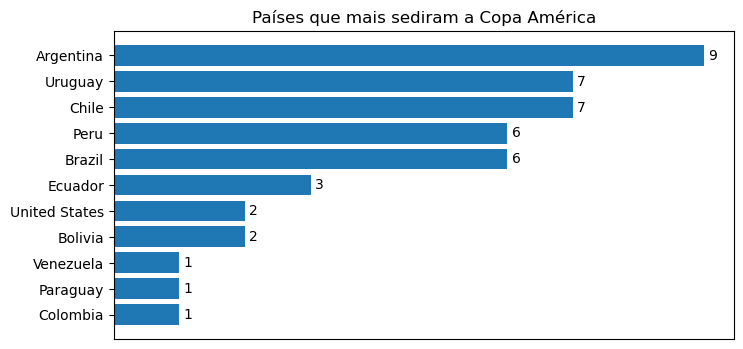

In [8]:
# País-sede
plt.figure(figsize=(8, 4))

agg_host = df.groupby('Host_country')['Edition'].count().sort_values().reset_index().rename(columns={'Host_country':'Country','Edition':'Host_n'})

bars = plt.barh(agg_host['Country'],agg_host['Host_n'])

plt.title('Países que mais sediram a Copa América')
plt.bar_label(bars, padding=3)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()

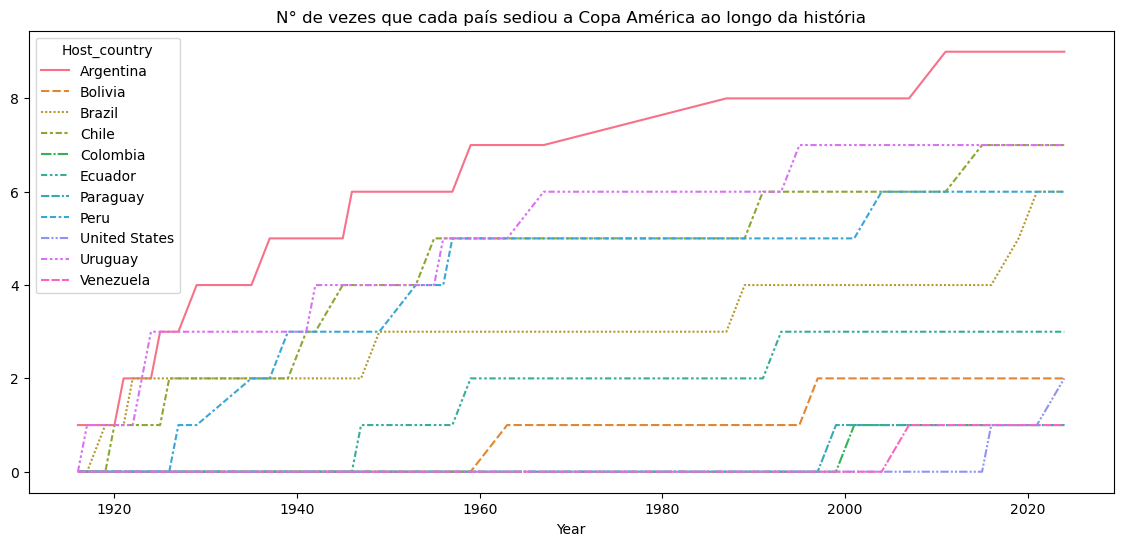

In [9]:
host_country_pivot = df.pivot_table(index='Year', columns='Host_country', values='Edition', aggfunc='count').transform('cumsum').ffill().fillna(0)

plt.figure(figsize=(14, 6))
sns.lineplot(host_country_pivot)
plt.title('N° de vezes que cada país sediou a Copa América ao longo da história')
plt.show()

Observamos que as 48 edições da Copa América tiveram 11 países-sede diferentes e que um grupo de países teve mais oportunidades de sediar a competição, principalmente nos primeiros 50 anos do torneio.

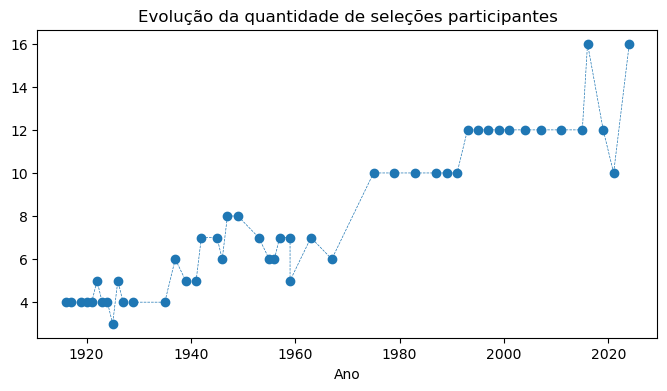

In [10]:
# Quantidade de seleções participantes
fig = plt.figure(figsize=(8, 4))

plt.plot(df['Year'], df['Teams'], marker='o', linestyle='dashed', linewidth=0.5)
plt.title('Evolução da quantidade de seleções participantes')
plt.xlabel('Ano')

plt.show()

Observamos que ao longo dos anos, houve uma tendência de aumento no número de seleções participantes.

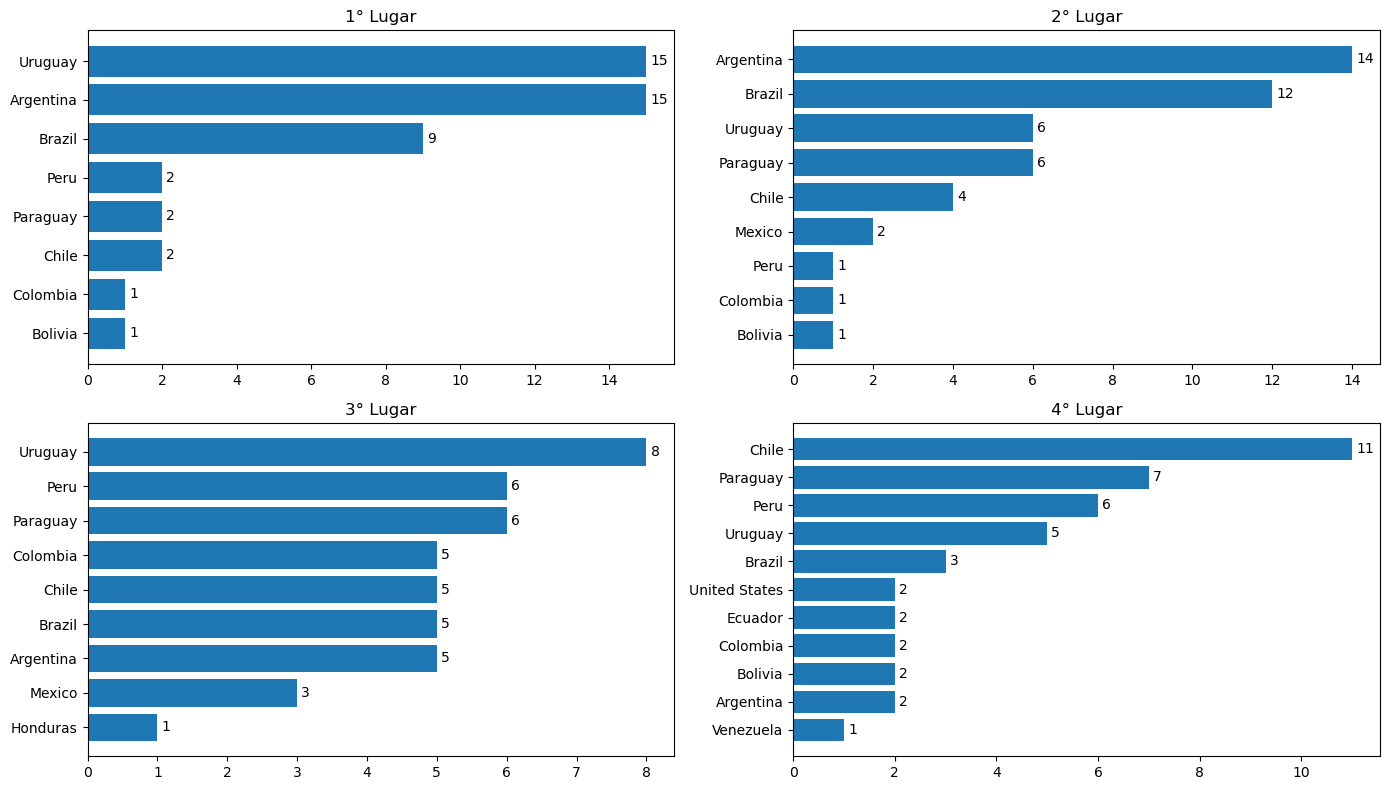

In [11]:
# Colocações
fig = plt.figure(figsize=(14, 8))

agg_first = df.groupby('First_place')['Edition'].count().sort_values().reset_index().rename(columns={'First_place':'Country', 'Edition':'First_place'})
agg_second = df.groupby('Second_place')['Edition'].count().sort_values().reset_index().rename(columns={'Second_place':'Country', 'Edition':'Second_place'})
agg_third = df.groupby('Third_place')['Edition'].count().sort_values().reset_index().rename(columns={'Third_place':'Country', 'Edition':'Third_place'})
agg_fourth = df.groupby('Fourth_place')['Edition'].count().sort_values().reset_index().rename(columns={'Fourth_place':'Country', 'Edition':'Fourth_place'})

plt.subplot(221)
bars1 = plt.barh(agg_first['Country'],agg_first['First_place'])
plt.title('1° Lugar')
plt.bar_label(bars1, padding=3)

plt.subplot(222)
bars2 = plt.barh(agg_second['Country'],agg_second['Second_place'])
plt.title('2° Lugar')
plt.bar_label(bars2, padding=3)

plt.subplot(223)
bars3 = plt.barh(agg_third['Country'],agg_third['Third_place'])
plt.title('3° Lugar')
plt.bar_label(bars3, padding=3)

plt.subplot(224)
bars4 = plt.barh(agg_fourth['Country'],agg_fourth['Fourth_place'])
plt.title('4° Lugar')
plt.bar_label(bars4, padding=3)

plt.tight_layout()
plt.show()


Observamos que as seleções da Argentina e Uruguai estão bem à frente no número de títulos do Brasil, que por sua vez está bem à frente dos demais. Nas 48 edições houveram apenas 8 campeões diferentes.

In [12]:
agg_ranking = agg_first.merge(agg_second, on='Country', how='outer').merge(agg_third, on='Country', how='outer').merge(agg_fourth, on='Country', how='outer').fillna(0)
agg_ranking[['First_place', 'Second_place', 'Third_place', 'Fourth_place']] = agg_ranking[['First_place', 'Second_place', 'Third_place', 'Fourth_place']].astype(int)
agg_ranking['Top_4'] = agg_ranking.sum(axis=1, numeric_only=True)
agg_ranking = agg_ranking.sort_values(by=['Top_4'], ascending=False).reset_index(drop=True)
agg_ranking

,Country,First_place,Second_place,Third_place,Fourth_place,Top_4
0,Argentina,15,14,5,2,36
1,Uruguay,15,6,8,5,34
2,Brazil,9,12,5,3,29
3,Chile,2,4,5,11,22
4,Paraguay,2,6,6,7,21
5,Peru,2,1,6,6,15
6,Colombia,1,1,5,2,9
7,Mexico,0,2,3,0,5
8,Bolivia,1,1,0,2,4
9,Ecuador,0,0,0,2,2


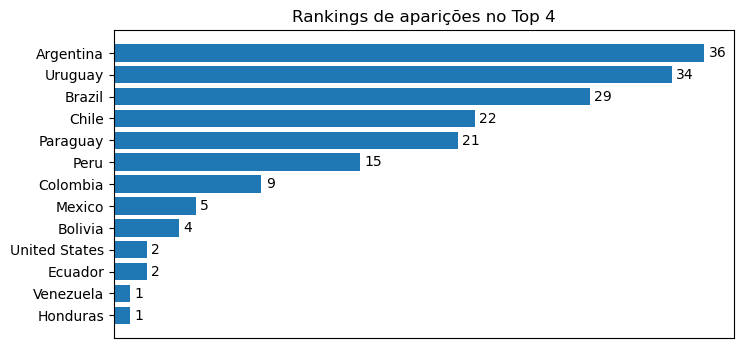

In [13]:
fig = plt.figure(figsize=(8, 4))

agg_ranking = agg_ranking.sort_values(by=['Top_4']).reset_index(drop=True)

bars = plt.barh(agg_ranking['Country'],agg_ranking['Top_4'])

plt.title('Rankings de aparições no Top 4')
plt.bar_label(bars, padding=3)
plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)

plt.show()

Observando número de aparições no Top 4, vemos um padrão similar ao número de títulos, com Argetina e Uruguai à frente e o Brasil logo atrás, com uma boa distância dos demais. Notamos também uma maior variedade de seleções presentes, com 13 seleções diferentes aparecendo.

In [14]:
# Meses do torneio

agg_start_month = df.groupby('Start_month')['Edition'].count().sort_values().reset_index().rename(columns={'Start_month':'Month', 'Edition':'Start'})
agg_end_month = df.groupby('End_month')['Edition'].count().sort_values().reset_index().rename(columns={'End_month':'Month', 'Edition':'End'})

agg_month = agg_start_month.merge(agg_end_month, on='Month', how='outer').fillna(0)
agg_month[['Start', 'End']] = agg_month[['Start', 'End']].astype(int)

agg_month.sort_values(by='Start', ascending=False).reset_index(drop=True)

,Month,Start,End
0,June,10,2
1,July,9,15
2,January,7,1
3,October,5,4
4,February,3,7
5,March,3,3
6,November,3,5
7,September,3,1
8,December,2,5
9,April,1,3


Observamos que a maioria dos torneios foi realizada no meio do ano, durante os meses de Junho e Julho.

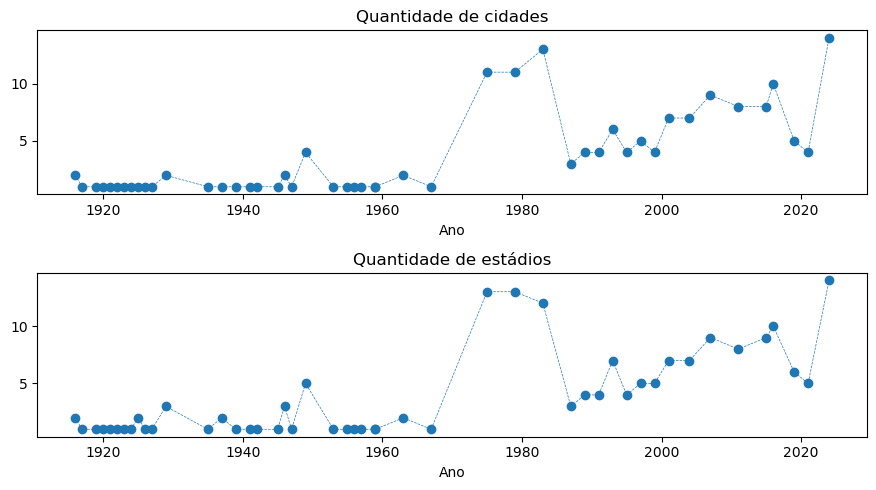

In [15]:
# Quantidade de cidades e estádios que receberam jogos
fig = plt.figure(figsize=(9, 5))

plt.subplot(211)
plt.plot(df['Year'], df['N_of_cities'], marker='o', linestyle='dashed', linewidth=0.5)
plt.title('Quantidade de cidades')
plt.xlabel('Ano')

plt.subplot(212)
plt.plot(df['Year'], df['N_of_stadiums'], marker='o', linestyle='dashed', linewidth=0.5)
plt.title('Quantidade de estádios')
plt.xlabel('Ano')

plt.tight_layout()
plt.show()

O maior número de cidades e estádios entre os anos 70 e 80 se deve ao fato de que as edições de 75, 79 e 83 não tiveram um país-sede fixo, as partidas foram disputadas em estádios no país com o mando de campo. Ainda assim, com algumas ressalvas, observamos uma tendência de crescimento neste números.

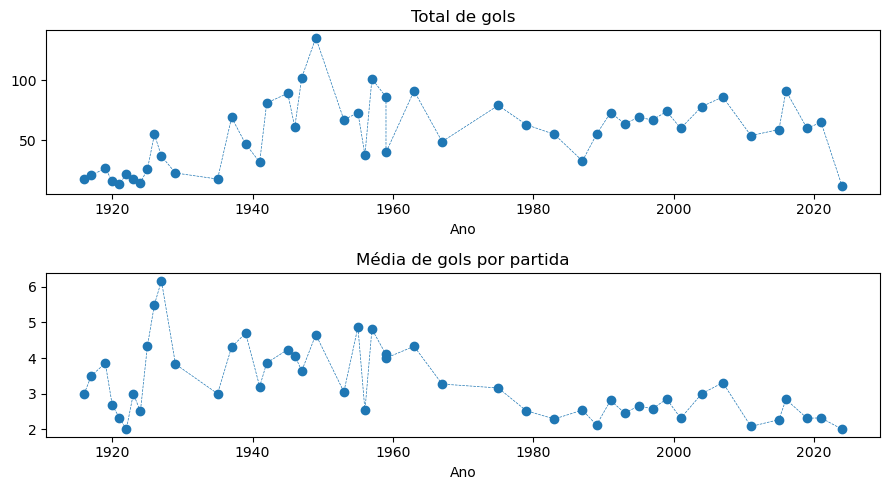

In [16]:
# Média e total de gols
fig = plt.figure(figsize=(9, 5))

plt.subplot(211)
plt.plot(df['Year'], df['Total_goals'], marker='o', linestyle='dashed', linewidth=0.5)
plt.title('Total de gols')
plt.xlabel('Ano')

plt.subplot(212)
plt.plot(df['Year'], df['Average_goals'], marker='o', linestyle='dashed', linewidth=0.5)
plt.title('Média de gols por partida')
plt.xlabel('Ano')

plt.tight_layout()
plt.show()

Observamos uma grande variação no total de gols marcados em virtude da quantidade de partidas não ser constante ao longo das edições do torneio. Em relação à media de gols por partida, observamos uma tendência de queda, possivelmente em virtude das mudanças ocorridas na dinâmica e nas táticas do jogo ao longo do tempo.

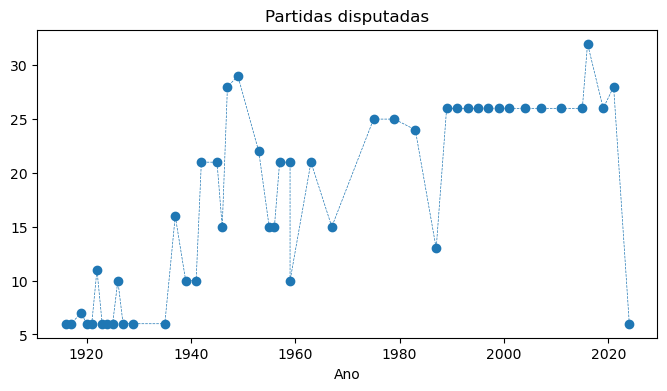

In [17]:
# Partidas disputadas
fig = plt.figure(figsize=(8, 4))

plt.plot(df['Year'], df['Matches_played'], marker='o', linestyle='dashed', linewidth=0.5)
plt.title('Partidas disputadas')
plt.xlabel('Ano')

plt.show()

Observamos que o número de partidas nas primeiras edições era bem menor, e que houve uma crescente neste valor ao longo do tempo.

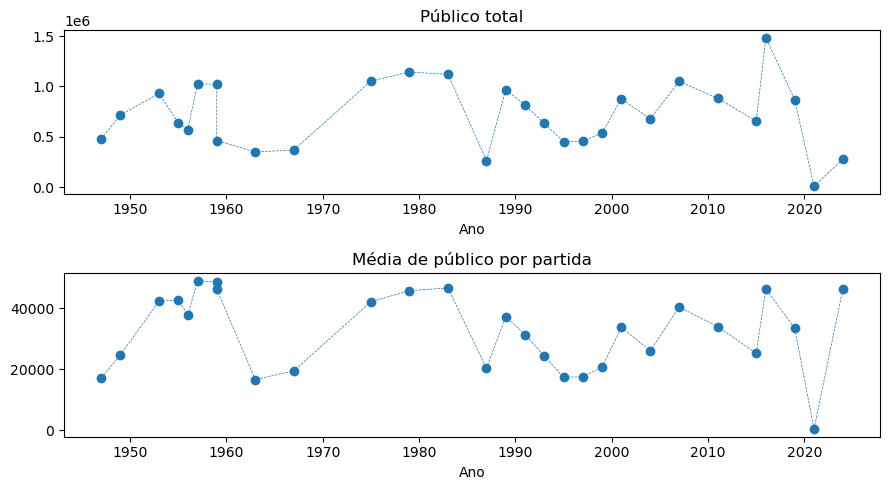

In [18]:
# Média e total de público
fig = plt.figure(figsize=(9, 5))

plt.subplot(211)
plt.plot(df['Year'], df['Total_attendance'], marker='o', linestyle='dashed', linewidth=0.5)
plt.title('Público total')
plt.xlabel('Ano')

plt.subplot(212)
plt.plot(df['Year'], df['Average_attendance'], marker='o', linestyle='dashed', linewidth=0.5)
plt.title('Média de público por partida')
plt.xlabel('Ano')

plt.tight_layout()
plt.show()

Observa-se que em linhas gerais, desde que este valor passou a ser contabilizado, o total de público permaneceu em valores entre 500,000 e 1,000,000, com as exceções da edição de 2016 (que foi maior, possivelmente em virtude do fato de ser a edição que marcava os 100 anos do torneio) e de 2021 (que foi menor, em virtude do fato de ter sido durante o período da pandemia da COVID-19).

### Análise Multivariada

In [37]:
# Nº de vezes que o país sediou o torneio x Perfomance

host_ranking = agg_host.merge(agg_ranking, on='Country', how='left').sort_values(by='Host_n', ascending=False).reset_index(drop=True)

host_ranking

,Country,Host_n,First_place,Second_place,Third_place,Fourth_place,Top_4
0,Argentina,9,15,14,5,2,36
1,Chile,7,2,4,5,11,22
2,Uruguay,7,15,6,8,5,34
3,Brazil,6,9,12,5,3,29
4,Peru,6,2,1,6,6,15
5,Ecuador,3,0,0,0,2,2
6,Bolivia,2,1,1,0,2,4
7,United States,2,0,0,0,2,2
8,Colombia,1,1,1,5,2,9
9,Paraguay,1,2,6,6,7,21


In [38]:
df_corr = host_ranking[['Host_n','First_place', 'Second_place', 'Third_place', 'Fourth_place']].corr()
df_corr.iloc[0:1,1:].style.background_gradient(cmap='YlOrRd', axis=1)

,First_place,Second_place,Third_place,Fourth_place
Host_n,0.767421,0.675204,0.556469,0.357125


Observamos que as 5 seleções que mais sediaram o torneio também estão entre as 6 com mais aparições no top 4.

Observamos que existe uma correlação positiva entre sediar a Copa América e a colocação, mas esta pode ser devida à diferença de qualidade entre os times, visto que as seleções mais tradicionais também sediaram mais vezes o torneio.

In [172]:
# Nº de participantes x Média de gols e público
teams_averages = df.groupby(['Teams'])[['Average_goals', 'Average_attendance']].mean().reset_index().style.format({'Average_goals':'{:.2f}', 'Average_attendance':'{:.0f}'})
teams_averages

,Teams,Average_goals,Average_attendance
0,3,4.33,
1,4,3.39,
2,5,3.88,46200
3,6,3.81,33349
4,7,4.07,39104
5,8,4.15,20934
6,10,2.54,31954
7,12,2.58,27260
8,16,2.42,46395


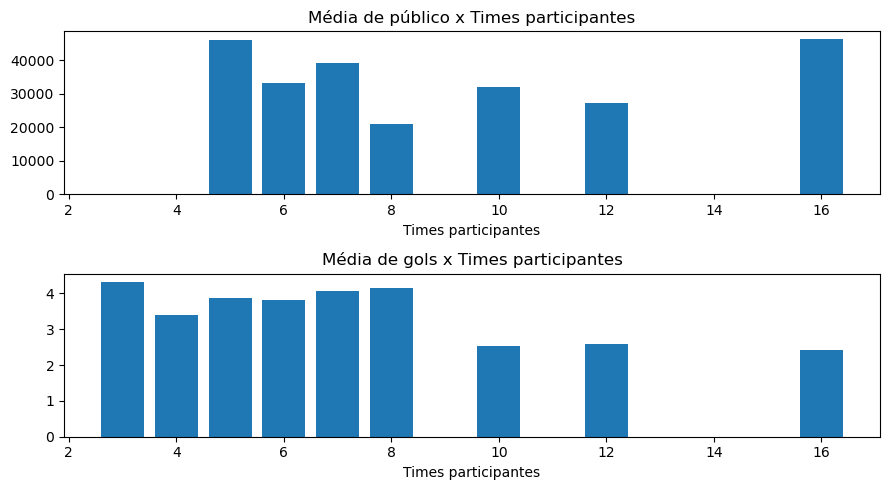

In [173]:
fig = plt.figure(figsize=(9, 5))

teams_averages = teams_averages.data.fillna(0)

plt.subplot(211)
plt.bar(teams_averages['Teams'], teams_averages['Average_attendance'])
plt.title('Média de público x Times participantes')
plt.xlabel('Times participantes')

plt.subplot(212)
plt.bar(teams_averages['Teams'], teams_averages['Average_goals'])
plt.title('Média de gols x Times participantes')
plt.xlabel('Times participantes')

plt.tight_layout()
plt.show()

A média de público não parece ter relação direta com o número de seleções participantes. Já a média de gols apresenta uma tendência de queda quando a quantidade de seleções é maior. Isso pode ter relação com o número de partidas maior, que tende a diluir a influencia de grandes placares, ou como foi discutido anteriormente, à mudanças na dinâmica e nas táticas do jogo ao longo do tempo, visto que os torneios mais atuais tem mais participantes.

In [179]:
# Nº de cidades e estádios x Média de público

cities_attendance = df.groupby(['N_of_cities'])[['Average_attendance']].mean().reset_index().style.format({'Average_attendance':'{:.0f}'}).data
stadiums_attendance = df.groupby(['N_of_stadiums'])[['Average_attendance']].mean().reset_index().style.format({'Average_attendance':'{:.0f}'}).data

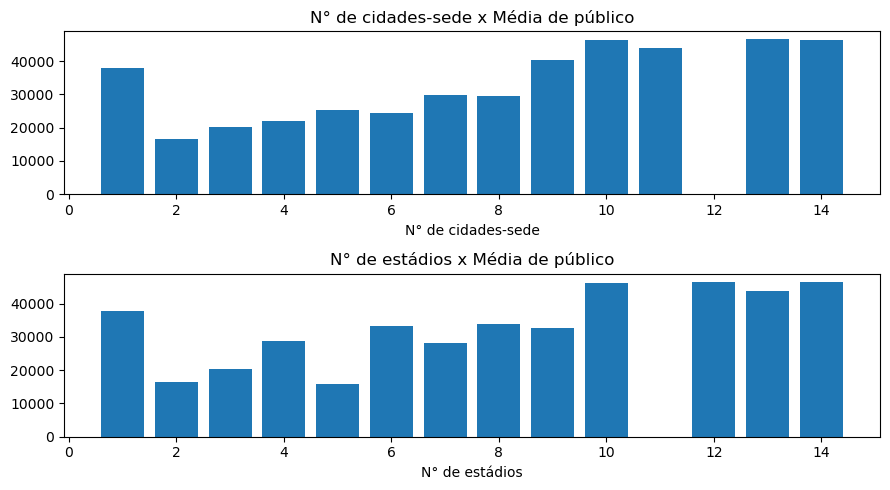

In [185]:
fig = plt.figure(figsize=(9, 5))

plt.subplot(211)
plt.bar(cities_attendance['N_of_cities'], cities_attendance['Average_attendance'])
plt.title('N° de cidades-sede x Média de público')
plt.xlabel('N° de cidades-sede')

plt.subplot(212)
plt.bar(stadiums_attendance['N_of_stadiums'], stadiums_attendance['Average_attendance'])
plt.title('N° de estádios x Média de público')
plt.xlabel('N° de estádios')


plt.tight_layout()
plt.show()

Uma quantidade maior de cidades-sede e estádios parece refletir em uma média de público maior. A exceção é para o torneio que foi realizado apenas em 1 estádio, que possuía grande capacidade e conseguiu concentrar o público.

In [191]:
# Gols x Média de público
goals_attendance = df[['Average_goals', 'Average_attendance']]
df_corr = goals_attendance.corr()
df_corr.iloc[0:1,1:].style.background_gradient(cmap='YlOrRd', axis=1)

,Average_attendance
Average_goals,0.151888


Não parece haver uma relação direta entre a média de gols marcados e a média de público.